In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D,
                                     LayerNormalization, MaxPooling2D, Reshape, MultiHeadAttention,
                                     GlobalAveragePooling1D, Flatten, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# --- Paths và tham số ---
root_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed/"
paths = [
    os.path.join(root_dir, "im_Dyskeratotic", "im_Dyskeratotic", "CROPPED"),
    os.path.join(root_dir, "im_Koilocytotic", "im_Koilocytotic", "CROPPED"),
    os.path.join(root_dir, "im_Metaplastic", "im_Metaplastic", "CROPPED"),
    os.path.join(root_dir, "im_Parabasal", "im_Parabasal", "CROPPED"),
    os.path.join(root_dir, "im_Superficial-Intermediate", "im_Superficial-Intermediate", "CROPPED")
]

height, width, channels = 64, 64, 3
num_classes = len(paths)

# --- Load dữ liệu ---
def load_images_from_paths(paths, img_size=(height, width)):
    images = []
    labels = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    for idx, p in enumerate(paths):
        if not os.path.exists(p):
            print(f"Warning: path not found {p}")
            continue
        for file in os.listdir(p):
            if not file.lower().endswith(valid_extensions):
                continue
            try:
                img_path = os.path.join(p, file)
                img = Image.open(img_path).convert('RGB').resize(img_size)
                img = np.array(img).astype(np.float32) / 255.0
                if img.shape != (height, width, channels):
                    continue
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Failed loading {file}: {e}")
                continue
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

data, labels = load_images_from_paths(paths)
labels_one_hot = tf.one_hot(labels, depth=num_classes).numpy()

X_train, X_tmp, y_train, y_tmp = train_test_split(
    data, labels_one_hot, test_size=0.3, random_state=40, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=40, stratify=np.argmax(y_tmp, axis=1))

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# --- Positional Encoding ---
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :], d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# --- Transformer Block ---
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# --- Conv + Multi-head attention block (CMT Block) ---
class CMTBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, conv_kernel=3, rate=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.conv_kernel = conv_kernel
        self.rate = rate
        
        # Convolution branch
        self.conv = Conv2D(embed_dim, conv_kernel, padding='same', activation='relu')
        self.norm1 = LayerNormalization(epsilon=1e-6)
        
        # Transformer branch
        self.flatten_to_seq = Reshape((-1, embed_dim))  # flatten H*W to sequence
        self.pos_encoding = PositionalEncoding(position=height*width, d_model=embed_dim)
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.norm3 = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(rate)

    def call(self, inputs, training=None):
        # Conv branch
        x = self.conv(inputs)
        x = self.norm1(x)
    
        # Transformer branch
        seq = self.flatten_to_seq(x)  # [batch, seq_len, embed_dim]
        seq = self.pos_encoding(seq)
    
        attn_out = self.mha(seq, seq)
        attn_out = self.dropout(attn_out, training=training)
        out1 = self.norm2(seq + attn_out)
    
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout(ffn_out, training=training)
        seq_out = self.norm3(out1 + ffn_out)
    
        # Lấy kích thước H, W động
        B = tf.shape(x)[0]
        H = tf.shape(x)[1]
        W = tf.shape(x)[2]
        x_out = tf.reshape(seq_out, (B, H, W, -1))
    
        # Residual add conv and transformer features
        return x + x_out
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "conv_kernel": self.conv_kernel,
            "rate": self.rate
        })
        return config


# --- CMT Model ---
def create_cmt_model(input_shape=(height, width, channels), num_classes=num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = MaxPooling2D()(x)
    
    x = CMTBlock(embed_dim=64, num_heads=4, ff_dim=128)(x)
    x = MaxPooling2D()(x)
    
    x = CMTBlock(embed_dim=128, num_heads=4, ff_dim=256)(x)
    x = MaxPooling2D()(x)
    
    x = GlobalAveragePooling2D()(x)
    features = Dense(256, activation='relu', name="features")(x)
    x = Dropout(0.3)(features)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = create_cmt_model()

# --- Train Model ---
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_cmt_model_V3.keras", save_best_only=True, monitor="val_accuracy"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5),
]

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=callbacks
)

model.load_weights("best_cmt_model_V3.keras")

# --- Dự đoán trực tiếp bằng model CMT ---
val_probs = model.predict(X_val)
test_probs = model.predict(X_test)

val_preds_cmt = np.argmax(val_probs, axis=1)
test_preds_cmt = np.argmax(test_probs, axis=1)

y_val_int = np.argmax(y_val, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# --- In kết quả đánh giá ---
print("Validation Accuracy (CMT Model):", accuracy_score(y_val_int, val_preds_cmt))
print("Test Accuracy (CMT Model):", accuracy_score(y_test_int, test_preds_cmt))
print("Classification Report (CMT Model):\n", classification_report(y_test_int, test_preds_cmt))


Epoch 1/100
45/45 [==============================] - 22s 246ms/step - loss: 1.4708 - accuracy: 0.3853 - val_loss: 1.0964 - val_accuracy: 0.5107
Epoch 2/100
45/45 [==============================] - 10s 230ms/step - loss: 1.1538 - accuracy: 0.4940 - val_loss: 1.1402 - val_accuracy: 0.5453
Epoch 3/100
45/45 [==============================] - 11s 234ms/step - loss: 1.0113 - accuracy: 0.5935 - val_loss: 0.8424 - val_accuracy: 0.6507
Epoch 4/100
45/45 [==============================] - 11s 238ms/step - loss: 0.9185 - accuracy: 0.6535 - val_loss: 0.9481 - val_accuracy: 0.6227
Epoch 5/100
45/45 [==============================] - 11s 238ms/step - loss: 0.8849 - accuracy: 0.6817 - val_loss: 0.6993 - val_accuracy: 0.7677
Epoch 6/100
45/45 [==============================] - 11s 239ms/step - loss: 0.7871 - accuracy: 0.7082 - val_loss: 0.6656 - val_accuracy: 0.7644
Epoch 7/100
45/45 [==============================] - 11s 239ms/step - loss: 0.7294 - accuracy: 0.7347 - val_loss: 0.6143 - val_accuracy:

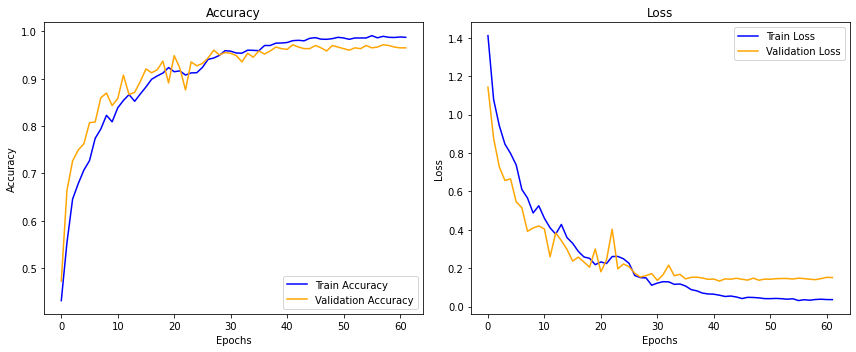

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- Visualize Training History ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()






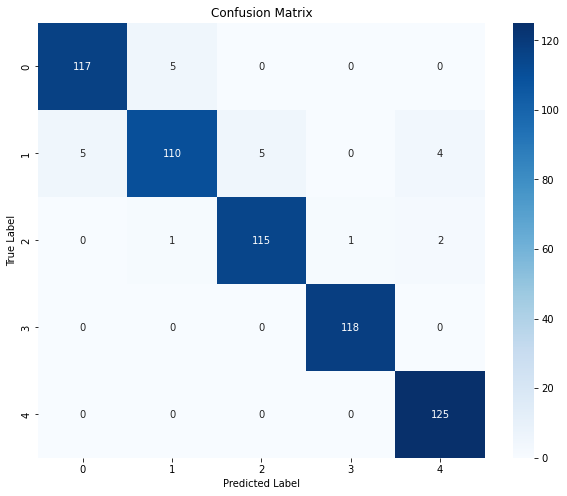

In [3]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test_int, test_preds_cmt)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(len(np.unique(y_test_int))),
            yticklabels=range(len(np.unique(y_test_int))))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (CMT Model)')
plt.show()

10 Test Predictions vs Actual Labels:
Prediction: 1, Actual: 1
Prediction: 2, Actual: 2
Prediction: 0, Actual: 0
Prediction: 2, Actual: 2
Prediction: 3, Actual: 2
Prediction: 3, Actual: 3
Prediction: 3, Actual: 3
Prediction: 3, Actual: 3
Prediction: 0, Actual: 0
Prediction: 2, Actual: 2


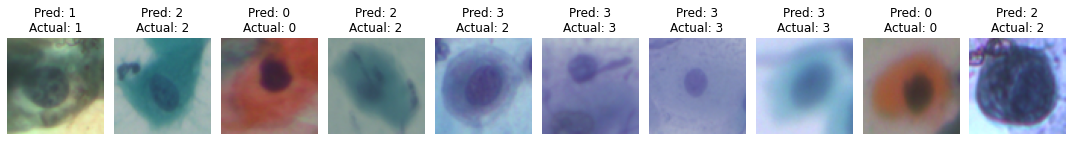

In [4]:
# --- Display 10 Predictions vs Actual Labels ---
print("10 Test Predictions vs Actual Labels (CMT Model):")
for i in range(10):
    print(f"Prediction: {test_preds_cmt[i]}, Actual: {y_test_int[i]}")

# --- Display Images with Predictions and Actual Labels ---
def display_images_with_predictions(X_test, y_test_pred, y_test_int, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_test[i].squeeze(), cmap='gray')  # Adjust `squeeze()` if using grayscale
        plt.title(f"Pred: {y_test_pred[i]}\nActual: {y_test_int[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call function to display images
display_images_with_predictions(X_test, test_preds_cmt, y_test_int)

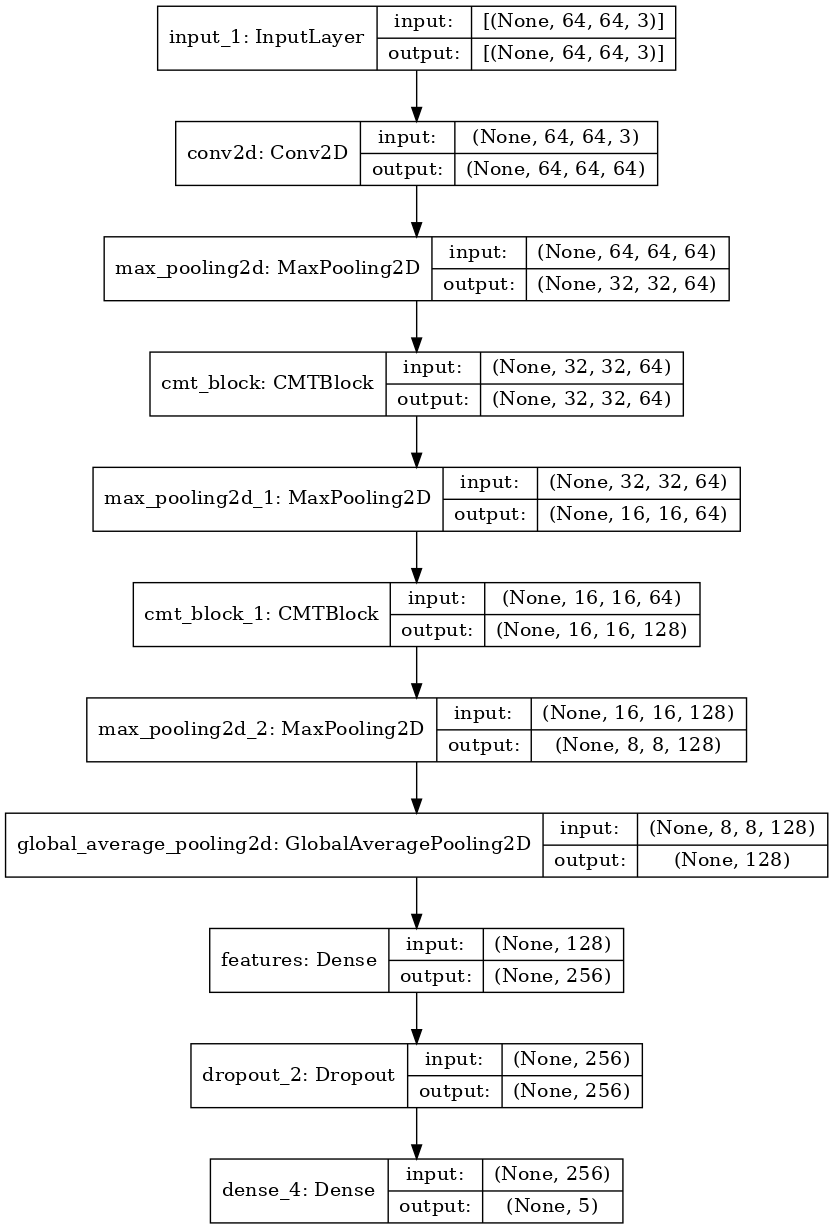

In [3]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=False, dpi=100)